<a href="https://colab.research.google.com/github/KhoaLearn/Estimating-Market-Implied-Probability-of-Default-for-Corporate-Bonds/blob/main/Estimating_Market_Implied_Probability_of_Default_for_Corporate_Bonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Collection

## Install Playwright and Dependencies

In [ ]:
!playwright install
!pip install playwright

161.3 MiB [] 0% 0.0s161.3 MiB [] 0% 39.5s161.3 MiB [] 0% 33.9s161.3 MiB [] 0% 24.9s161.3 MiB [] 0% 22.8s161.3 MiB [] 0% 21.3s161.3 MiB [] 0% 20.6s161.3 MiB [] 0% 18.4s161.3 MiB [] 0% 16.3s161.3 MiB [] 1% 15.2s161.3 MiB [] 1% 14.5s161.3 MiB [] 1% 14.1s161.3 MiB [] 1% 13.6s161.3 MiB [] 1% 12.9s161.3 MiB [] 1% 13.4s161.3 MiB [] 1% 13.5s161.3 MiB [] 2% 13.4s161.3 MiB [] 2% 13.1s161.3 MiB [] 2% 12.9s161.3 MiB [] 2% 13.3s161.3 MiB [] 2% 13.5s161.3 MiB [] 2% 13.7s161.3 MiB [] 2% 13.8s161.3 MiB [] 2% 13.7s161.3 MiB [] 3% 13.8s161.3 MiB [] 3% 13.7s161.3 MiB [] 3% 13.8s161.3 MiB [] 3% 13.4s161.3 MiB [] 3% 13.1s161.3 MiB [] 3% 12.7s161.3 MiB [] 4% 12.6s161.3 MiB [] 4% 12.7s161.3 MiB [] 4% 12.9s161.3 MiB [] 4% 12.5s161.3 MiB [] 5% 12.2s161.3 MiB [] 5% 12.1s161.3 MiB [] 5% 11.7s161.3 MiB [] 5% 11.4s161.3 MiB [] 6% 11.2s161.3 MiB [] 6% 10.8s161.3 MiB [] 6% 10.7s161.3 MiB [] 7% 10.4s161.3 MiB [] 7% 9.9s161.3 MiB [] 8% 9.3s161.3 MiB [] 8% 9.1s161.3 MiB [] 8% 8.9s161.3 MiB [] 9% 9.0s161.3 MiB [] 9% 8.8

In [ ]:
!apt-get update
!apt-get install -y libwoff1 libopus0 libwebp6 libwebpdemux2 libenchant1c2a libgudev-1.0-0 libsecret-1-0 libhyphen0 libgdk-pixbuf2.0-0 libegl1 libgles2 libxslt1.1 libevent-2.1-6 libnotify4 libxslt1.1 libatk1.0-0 libatk-bridge2.0-0 libcups2 libdbus-1-3 libxcomposite1 libxrandr2 libxdamage1 libxkbcommon0 libxshmfence1 libgl1 libx11-xcb1 libxcb1 libegl1-mesa libx11-6 libxext6 libsm6 libxrender1 libxss1

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,263 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,674 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updat

## Scrape Data

In [ ]:
from playwright.async_api import async_playwright
import pandas as pd
import nest_asyncio
import asyncio

# Apply nest_asyncio to allow running async code in Jupyter/Colab
nest_asyncio.apply()

async def scrape_bond_data(issuer_name, date_start, date_end):
    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=True)
        context = await browser.new_context(viewport={"width": 1920, "height": 1080})
        page = await context.new_page()
        await page.goto("https://www.finra.org/finra-data/fixed-income/corp-and-agency")
        await page.locator('input[placeholder="Issuer Name"]').fill(issuer_name)
        await page.locator("input#form-name").nth(0).fill(date_start)
        await page.locator("input#form-name").nth(1).fill(date_end)
        await page.locator('text="Show Results"').click()
        await page.wait_for_timeout(5000)
        await page.locator("ag-grid-angular").evaluate("""element => { element.style.height = "1500px"; element.style.width = "4500px"; }""")
        await page.wait_for_timeout(2000)
        column_ids = ["issueSymbolIdentifier", "issuerName", "isCallable", "productSubTypeCode", "couponRate", "maturityDate", "industryGroup", "moodysRating", "standardAndPoorsRating", "lastSalePrice", "lastSaleYield"]
        data = {}
        for column_id in column_ids:
            column_data = await page.locator(f"div[col-id='{column_id}']").all_text_contents()
            data[column_id] = column_data[1:]  # Skip the header
        await browser.close()
        return pd.DataFrame.from_dict(data)

issuer_name = "hess"
date_start = "2028-01-01"
date_end = "2050-01-01"

# Run the scraping function
bond_prices_df = asyncio.run(scrape_bond_data(issuer_name, date_start, date_end))
bond_prices_df.head()

,issueSymbolIdentifier,issuerName,isCallable,productSubTypeCode,couponRate,maturityDate,industryGroup,moodysRating,standardAndPoorsRating,lastSalePrice,lastSaleYield
0,HES.GF,AMERADA HESS CORP,N,CORP,7.3,2031-08-15,OILG,Baa3,BBB-,112.621,5.151696
1,HES.GG,AMERADA HESS CORP,N,CORP,7.125,2033-03-15,OILG,Baa3,BBB-,113.436,5.18099
2,HES4405830,HESS CORP,Y,CORP,5.8,2047-04-01,OILG,Baa3,BBB-,103.121,5.563286
3,HES.GH,HESS CORP,N,CORP,6,2040-01-15,OILG,Baa3,BBB-,105.223,
4,HES.GI,HESS CORP,N,CORP,5.6,2041-02-15,OILG,Baa3,BBB-,101.106,5.497004


# Step 2: Data Cleaning and Transformation

## Data Cleaning

In [ ]:
# Convert data types
bond_prices_df["couponRate"] = pd.to_numeric(bond_prices_df["couponRate"], errors='coerce')
bond_prices_df["lastSalePrice"] = pd.to_numeric(bond_prices_df["lastSalePrice"], errors='coerce')
bond_prices_df["lastSaleYield"] = pd.to_numeric(bond_prices_df["lastSaleYield"], errors='coerce')
bond_prices_df["maturityDate"] = pd.to_datetime(bond_prices_df["maturityDate"], errors='coerce')

# Drop rows with missing values in specific columns
bond_prices_df.dropna(subset=["couponRate", "lastSalePrice", "lastSaleYield", "maturityDate"], inplace=True)

# Display the cleaned DataFrame
bond_prices_df.head()

,issueSymbolIdentifier,issuerName,isCallable,productSubTypeCode,couponRate,maturityDate,industryGroup,moodysRating,standardAndPoorsRating,lastSalePrice,lastSaleYield
0,HES.GF,AMERADA HESS CORP,N,CORP,7.300,2031-08-15,OILG,Baa3,BBB-,112.621,5.151696
1,HES.GG,AMERADA HESS CORP,N,CORP,7.125,2033-03-15,OILG,Baa3,BBB-,113.436,5.180990
2,HES4405830,HESS CORP,Y,CORP,5.800,2047-04-01,OILG,Baa3,BBB-,103.121,5.563286
4,HES.GI,HESS CORP,N,CORP,5.600,2041-02-15,OILG,Baa3,BBB-,101.106,5.497004
7,HES5392919,HESS MIDSTREAM OPERATIONS LP,Y,CORP,5.500,2030-10-15,OILG,Ba2,BB+,97.128,6.056198


## Data Transformation

In [ ]:
from datetime import datetime as dt

# Calculate maturity years
now = dt.now()
bond_prices_df["maturityYears"] = (bond_prices_df["maturityDate"] - now).dt.days / 365.25

# Filter bonds with maturity up to 5 years
filtered_bonds_df = bond_prices_df[(bond_prices_df["maturityYears"] > 0) & (bond_prices_df["maturityYears"] <= 5)]

# Display the transformed DataFrame
filtered_bonds_df.head()


,issueSymbolIdentifier,issuerName,isCallable,productSubTypeCode,couponRate,maturityDate,industryGroup,moodysRating,standardAndPoorsRating,lastSalePrice,lastSaleYield,maturityYears
9,HES5809240,HESS MIDSTREAM OPERATIONS LP,Y,CORP,6.500,2029-06-01,OILG,Ba2,BB+,102.064,5.927230,4.884326
12,HES4918686,HESS MIDSTREAM PARTNERS LP,Y,CORP,5.125,2028-06-15,OILG,Ba2,BB+,97.397,5.912309,3.923340


# Step 3: Estimating the Risk-Adjusted Discount Rate

## Calculate Market Rate of Return

In [ ]:
import yfinance as yfin
from datetime import date,timedelta
import matplotlib.pyplot as plt

yfin.pdr_override()

# Fetch risk-free rate
current_date = date.today()
past_date = current_date - timedelta(days=100)
ten_year_risk_free_rate_df = yfin.download("^TNX", past_date, current_date)
ten_year_risk_free_rate = ten_year_risk_free_rate_df.iloc[-1]["Adj Close"] / 100

# Define market risk premium
market_risk_premium = 0.0472
stock_market_beta = 1

# Calculate market rate of return
market_rate_of_return = ten_year_risk_free_rate + (stock_market_beta * market_risk_premium)

market_rate_of_return


yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


0.08912999839782715

# Step 4: Estimating Market-Implied Probability of Default

## Define the bonds_probability_of_default Function

In [ ]:
from sympy import symbols, solve
import numpy as np

P = symbols("P")

def bonds_probability_of_default(coupon, maturity_years, bond_price, principal_payment, risk_adjusted_discount_rate):
    semi_annual_coupon = coupon / 2
    times = np.arange(0.5, maturity_years + 0.5, 0.5)
    cashflows = np.append(np.repeat(semi_annual_coupon, len(times) - 1), semi_annual_coupon + principal_payment)
    prob_default_exp = sum([(cf * (1 - P) + principal_payment * 0.4 * P) / (1 + risk_adjusted_discount_rate)**t for cf, t in zip(cashflows, times)]) - bond_price
    implied_prob_default = solve(prob_default_exp, P)[0] * 100
    return max(implied_prob_default, 0.0)


## Estimate PD for Each Bond

In [ ]:
principal_payment = 100
risk_adjusted_discount_rate = market_rate_of_return

filtered_bonds_df["probability_of_default"] = filtered_bonds_df.apply(
    lambda row: bonds_probability_of_default(
        row["couponRate"],
        row["maturityYears"],
        row["lastSalePrice"],
        principal_payment,
        risk_adjusted_discount_rate
    ), axis=1
)

# Display the DataFrame with estimated probabilities of default
filtered_bonds_df.head()


<ipython-input-10-60c300d5ea15>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bonds_df["probability_of_default"] = filtered_bonds_df.apply(


,issueSymbolIdentifier,issuerName,isCallable,productSubTypeCode,couponRate,maturityDate,industryGroup,moodysRating,standardAndPoorsRating,lastSalePrice,lastSaleYield,maturityYears,probability_of_default
9,HES5809240,HESS MIDSTREAM OPERATIONS LP,Y,CORP,6.500,2029-06-01,OILG,Ba2,BB+,102.064,5.927230,4.884326,4.79862341652613
12,HES4918686,HESS MIDSTREAM PARTNERS LP,Y,CORP,5.125,2028-06-15,OILG,Ba2,BB+,97.397,5.912309,3.923340,5.26306224245310


# Step 5: Comparing PDs with Ratings-Implied PDs

In [ ]:
# Install necessary libraries
!pip install beautifulsoup4

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Load the HTML file
with open("/content/Default, Transition, and Recovery_ 2023 Annual Global Corporate Default And Rating Transition Study _ S&P Global Ratings.html", "r") as file:
    content = file.read()

# Find all tables in the document
tables = soup.find_all("table")

# Extract the table by index
transition_matrix_table = tables[19]

# Convert the HTML table to a pandas DataFrame
df = pd.read_html(str(transition_matrix_table))[0]

In [ ]:
# Flatten the multi-level column index
df.columns = [' '.join(col).strip() for col in df.columns.values]

# Drop unnecessary rows
df_cleaned = df.drop([0])  # Adjust indices based on inspection

# Drop columns with "Unnamed" in their header
df_cleaned = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Rename columns to remove unnecessary prefixes
df_cleaned.columns = df_cleaned.columns.str.replace("2023 One-year corporate transition rates by region (%) ", "")

# Reset the index
df_cleaned.set_index("From/to", inplace=True)

# Display the cleaned DataFrame
print(df_cleaned.head())

            AAA      AA       A     BBB      BB       B   CCC/C       D  \
From/to                                                                   
Global   Global  Global  Global  Global  Global  Global  Global  Global   
AAA      100.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
AA         0.00   96.81    1.42    0.00    0.00    0.00    0.00    0.00   
A          0.00    0.15   96.78    1.02    0.00    0.00    0.00    0.00   
BBB        0.00    0.00    1.61   92.68    0.97    0.43    0.11    0.11   

             NR  
From/to          
Global   Global  
AAA        0.00  
AA         1.77  
A          2.05  
BBB        4.09  


In [68]:
rating_mapping = {
    'AAA': 'AAA',
    'AA+': 'AA',
    'AA': 'AA',
    'AA-': 'AA',
    'A+': 'A',
    'A': 'A',
    'A-': 'A',
    'BBB+': 'BBB',
    'BBB': 'BBB',
    'BBB-': 'BBB',
    'BB+': 'BB',
    'BB': 'BB',
    'BB-': 'BB',
    'B+': 'B',
    'B': 'B',
    'B-': 'B',
    'CCC+': 'CCC/C',
    'CCC': 'CCC/C',
    'CCC-': 'CCC/C',
    'D': 'D'
}

In [72]:
filtered_bonds_df['standardAndPoorsRating'] = filtered_bonds_df['standardAndPoorsRating'].map(rating_mapping)


<ipython-input-72-d7acd94723ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bonds_df['standardAndPoorsRating'] = filtered_bonds_df['standardAndPoorsRating'].map(rating_mapping)


In [73]:
filtered_bonds_df

,issueSymbolIdentifier,issuerName,isCallable,productSubTypeCode,couponRate,maturityDate,industryGroup,moodysRating,standardAndPoorsRating,lastSalePrice,lastSaleYield,maturityYears,probability_of_default,ratings_implied_pd
9,HES5809240,HESS MIDSTREAM OPERATIONS LP,Y,CORP,6.500,2029-06-01,OILG,Ba2,BB,102.064,5.927230,4.884326,4.79862341652613,None
12,HES4918686,HESS MIDSTREAM PARTNERS LP,Y,CORP,5.125,2028-06-15,OILG,Ba2,BB,97.397,5.912309,3.923340,5.26306224245310,None


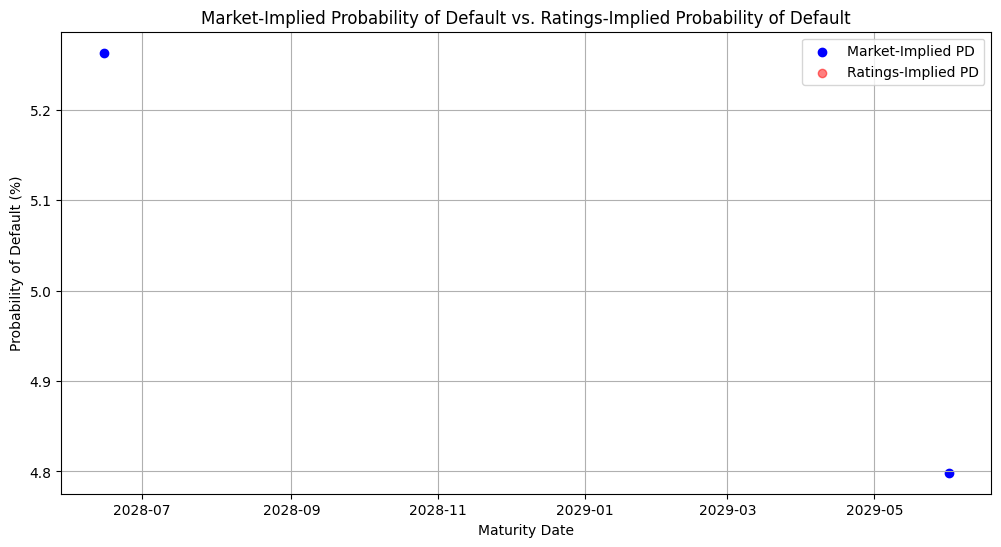

In [74]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(filtered_bonds_df["maturityDate"], filtered_bonds_df["probability_of_default"], label="Market-Implied PD", color='blue')
plt.scatter(filtered_bonds_df["maturityDate"], filtered_bonds_df["ratings_implied_pd"]*100, label="Ratings-Implied PD", color='red', alpha=0.5)
plt.title("Market-Implied Probability of Default vs. Ratings-Implied Probability of Default")
plt.xlabel("Maturity Date")
plt.ylabel("Probability of Default (%)")
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Conclusion

Market-Implied Probability of Default: two data points representing the market-implied probability of default for bonds maturing in 2028 and 2029. These points are in blue and indicate probabilities around 4.8% and 5.2%.